In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [4]:
print("ss")

ss


In [5]:
!pip install np_utils

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input, LSTM, concatenate, AveragePooling2D
from tensorflow.keras.layers import Subtract, Conv2D, GlobalMaxPooling2D, Reshape, Conv2DTranspose, UpSampling2D, Embedding
from tensorflow.keras import regularizers
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot as plt

import numpy as np

Using TensorFlow backend.


In [0]:
#parameters
epsilon = 0.01  #the quantity of perturbation we add to the images
step_pgd = 20   #the number of steps taken during the PGD algo
eta = 0.005     #used in PGD algo


#parameters

epsilon_l2 = 0.4  #the quantity of perturbation we add to the images norm L2
epsilon_inf = 0.031 #norm infini

step_pgd = 20   #the number of steps taken during the PGD algo
eta_l2 = 0.4     #used in PGD algo
eta_inf = 0.031

(Valeurs communément acceptées) Si input est dans [0, 1], alors epsilon doit être à 

0.031 max pour la norme infinie

0.4 max pour la norme 2 (pour que ce soit invisible)

Il n'y a pas de consciensus pour l'utilisation de la norme infinie ou 2 

# Data

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
x_train = x_train / 255
x_test = x_test / 255

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Network

In [0]:
# (Conv + ReLU + MaxPool)x3 + AvgPool + FC + ReLU + FC (fully connected)
input = tf.keras.Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x) 

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(10, activation='softmax')(x)


adversarial = keras.models.Model(inputs=input, outputs=x)
adversarial.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
history = adversarial.fit(x_train, y_train, batch_size=64, epochs=20, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 16s 404us/sample - loss: 1.7212 - accuracy: 0.3869 - val_loss: 1.5220 - val_accuracy: 0.4632
Epoch 2/20
40000/40000 [==============================] - 15s 380us/sample - loss: 1.4040 - accuracy: 0.5056 - val_loss: 1.3553 - val_accuracy: 0.5240
Epoch 3/20
40000/40000 [==============================] - 15s 375us/sample - loss: 1.2703 - accuracy: 0.5573 - val_loss: 1.2379 - val_accuracy: 0.5786
Epoch 4/20
40000/40000 [==============================] - 15s 376us/sample - loss: 1.1855 - accuracy: 0.5890 - val_loss: 1.1977 - val_accuracy: 0.5890
Epoch 5/20
40000/40000 [==============================] - 15s 368us/sample - loss: 1.1280 - accuracy: 0.6086 - val_loss: 1.1369 - val_accuracy: 0.6117
Epoch 6/20
40000/40000 [==============================] - 15s 366us/sample - loss: 1.0832 - accuracy: 0.6273 - val_loss: 1.1096 - val_accuracy: 0.6169
Epoch 7/20
40000/40000 [====================

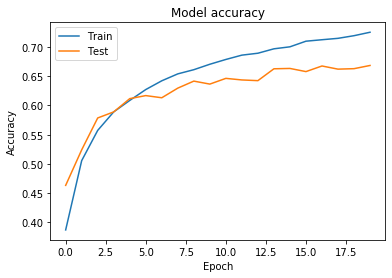

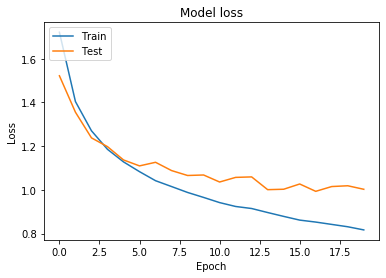

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Perturbations (FGSM, norme infinie)

In [0]:
#create the perturbations
#the perturbations are on the test set
image = tf.cast(x_test, tf.float32)
    
with tf.GradientTape() as tape:
  tape.watch(image)
  prediction = adversarial(image)
  loss = tf.keras.losses.MSE(y_test, prediction)
    
gradient = tape.gradient(loss, image)
    
perturbations_inf = tf.sign(gradient).numpy()*epsilon_inf 

perturbations_l2 = np.zeros((len(x_test),32,32,3))
for i in range(len(x_test)):
  perturbations_l2[i]=(epsilon_l2*gradient[i]/np.linalg.norm(gradient[i])).numpy()

x_test_fgsm = x_test + perturbations_inf
x_test_fgm = x_test + perturbations_l2

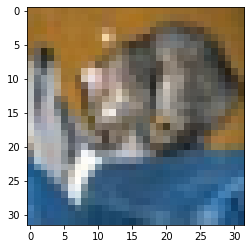

In [12]:
#the original image
plt.imshow(x_test[0].reshape((32, 32, 3)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


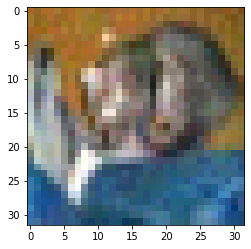

In [13]:
#the modified image (FGSM)
plt.imshow(x_test_fgsm[0].reshape((32, 32, 3)))
plt.show()

In [14]:
#results for the original image
print(adversarial.evaluate(x_test, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [15]:
#results for the modified image
print(adversarial.evaluate(x_test_fgsm, y_test))
print(adversarial.evaluate(x_test_fgm, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================



# Perturbations (PGD, norme infinie)

In [0]:

#create the perturbations

#Norme infinie 

x_test_pgd_inf = np.copy(x_test)
image_ref = tf.cast(x_test, tf.float32)
    
for step in range(step_pgd):
  image = tf.cast(x_test_pgd_inf, tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = adversarial(image)
    loss = tf.keras.losses.MSE(y_test, prediction)
      
  gradient = tape.gradient(loss, image)
  
  perturbations_inf = tf.sign(gradient).numpy()*eta_inf
  x_test_pgd_inf = x_test_pgd_inf + perturbations_inf
  x_test_pgd_inf = np.maximum(np.minimum(x_test_pgd_inf, x_test + epsilon), x_test - epsilon)

In [0]:
#Norme L2

x_test_pgd_l2 = np.copy(x_test)
image_ref = tf.cast(x_test, tf.float32)

for step in range(step_pgd):
  image = tf.cast(x_test_pgd_l2, tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = adversarial(image)
    loss = tf.keras.losses.MSE(y_test, prediction)
  
  gradient = tape.gradient(loss,image)

  perturbations_l2 = np.zeros((len(x_test),32,32,3))
  for i in range(len(x_test_pgd_l2)):
    perturbations_l2[i]=(eta_l2*gradient[i]/np.linalg.norm(gradient[i])).numpy()

  x_test_pgd_l2 = x_test_pgd_l2 + perturbations_l2
  x_test_pgd_l2 = np.maximum(np.minimum(x_test_pgd_l2,x_test + epsilon),x_test - epsilon)

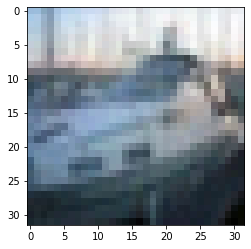

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


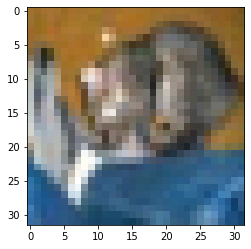

In [18]:
#the modified image (PGD)

#Norme Inf
plt.imshow(x_test_pgd_inf[2].reshape((32, 32, 3)))
plt.show()

#Norme L2
plt.imshow(x_test_pgd_l2[0].reshape((32, 32, 3)))
plt.show()

In [19]:

#Norme Inf 
print(adversarial.evaluate(x_test_pgd_inf, y_test))

#Norme L2 
print(adversarial.evaluate(x_test_pgd_l2, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
#create the perturbations
#the perturbations are on the test set
def process_fgsm(eps):
  image = tf.cast(x_test, tf.float32)
      
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = adversarial(image)
    loss = tf.keras.losses.MSE(y_test, prediction)
      
  gradient = tape.gradient(loss, image)
      
  perturbations = tf.sign(gradient).numpy()
  print(type(perturbations))
  print(perturbations.shape)

  x_test_fgsm = x_test + perturbations * eps
  return(x_test_fgsm)

In [0]:
eps_grid = [0.0001,0.001,0.01,0.031,0.05, 0.1]

<class 'numpy.ndarray'>
(10000, 32, 32, 3)


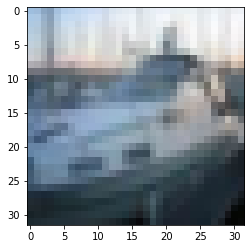

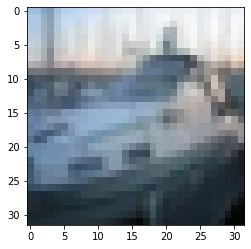

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

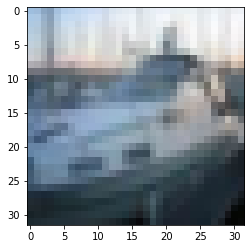

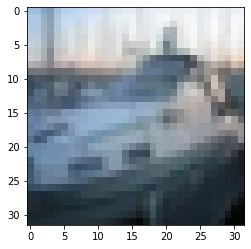

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

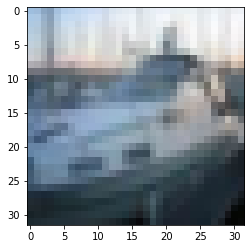

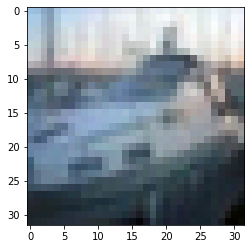

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

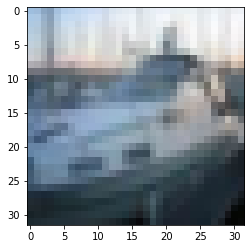

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


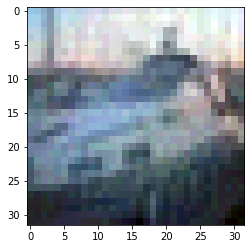

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

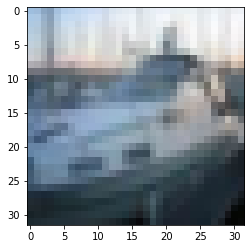

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


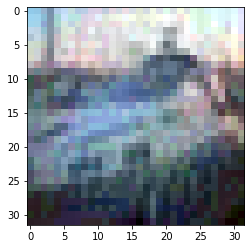

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

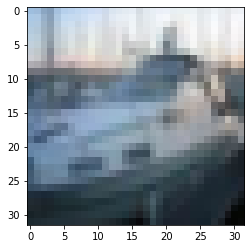

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


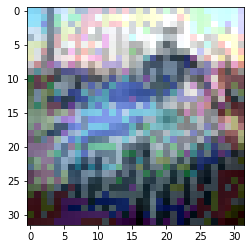

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

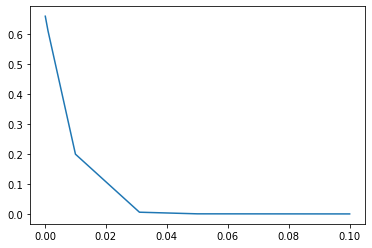

In [22]:
acc = []
for eps in eps_grid :
  x = process_fgsm(eps)
  plt.imshow(x_test[2].reshape((32, 32, 3)))
  plt.show()
  plt.imshow(x[2].reshape((32, 32, 3)))
  plt.show()
  acc.append(adversarial.evaluate(x, y_test)[1])
print(acc)
plt.plot(eps_grid,acc)

# Adversarial training

In [0]:
# (Conv + ReLU + MaxPool)x3 + AvgPool + FC + ReLU + FC (fully connected)
input = tf.keras.Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x) 

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

adversarial_trained = keras.models.Model(inputs=input, outputs=x)
adversarial_trained.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
#boucle
epochs = 10
x_train_adv = np.copy(x_train[:3500, :, :, :])
y_train_adv = np.copy(y_train[:3500])
histories = [0 for i in range(epochs)]
#training with the modified training set 
for i in range (epochs):
    histories[i] = adversarial_trained.fit(x_train_adv, y_train_adv, batch_size=64, epochs=1, validation_split=0.2)

    image = tf.cast(x_train_adv, tf.float32)

    with tf.GradientTape() as tape:
      tape.watch(image)
      prediction = adversarial_trained(image)
      loss = tf.keras.losses.MSE(y_train_adv, prediction)

    gradient = tape.gradient(loss, image)
    #tf.enable_eager_execution()
    print(tf.executing_eagerly())
    perturbations = tf.sign(gradient).numpy()
    x_train_adv = np.append(x_train_adv,x_train_adv[i*3500:, :, :, :] + perturbations[i*3500:,:,:,:] * epsilon,axis=0)
    print(x_train_adv.shape)
    y_train_adv = np.append(y_train_adv,y_train[:3500],axis=0)
    print(y_train_adv.shape)

Train on 2800 samples, validate on 700 samples
2800/2800 [==============================] - 2s 806us/sample - loss: 2.1896 - accuracy: 0.2007 - val_loss: 2.0274 - val_accuracy: 0.2529
True
(7000, 32, 32, 3)
(7000, 10)
Train on 5600 samples, validate on 1400 samples
5600/5600 [==============================] - 2s 351us/sample - loss: 1.9322 - accuracy: 0.3077 - val_loss: 1.8966 - val_accuracy: 0.2993
True
(10500, 32, 32, 3)
(10500, 10)
Train on 8400 samples, validate on 2100 samples
8400/8400 [==============================] - 3s 364us/sample - loss: 1.7999 - accuracy: 0.3592 - val_loss: 1.9040 - val_accuracy: 0.3081
True
(14000, 32, 32, 3)
(14000, 10)
Train on 11200 samples, validate on 2800 samples
11200/11200 [==============================] - 4s 389us/sample - loss: 1.6715 - accuracy: 0.4032 - val_loss: 1.9423 - val_accuracy: 0.2893
True
(17500, 32, 32, 3)
(17500, 10)
Train on 14000 samples, validate on 3500 samples
14000/14000 [==============================] - 5s 368us/sample - lo

InvalidArgumentError: ignored

In [0]:
#results for the original image
print(adversarial_trained.evaluate(x_test, y_test))
print(adversarial_trained.evaluate(x_test_fgsm, y_test))

In [0]:
## NES GRADIENT ALGORITHM 

In [0]:
def NES_grad(sigma, n_sample,n):
  g = np.zeros(n_sample)
  for i in range(n_sample):
    u = np.random.normal(0,1,N)
    g = g + adve

In [0]:
adversarial.predict(x_traik[0], batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
